In [1]:
from engine import Value
from nn import NeuralNetwork
from optim import SGD
from graphviz import Digraph
import inspect
import random
from criteria import accuracy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
import numpy as np
from matplotlib.lines import Line2D
from IPython.display import display_png
import math

In [2]:
# brew install graphviz
# conda install pydot
# conda install python-graphviz
# conda install graphviz
# conda install numpy==1.24.3
# conda install matplotlib==3.6.1

In [3]:
plt.rcParams['savefig.bbox'] = 'tight'

In [4]:
random.seed(42)
# threshold = 0.707107
threshold=2.50662827463

In [5]:
def retrieve_name(var):
    """
    This is a really hacky way to get a variable's name in the current runtime stack
    (hardcoded to look up exactly two frames for use in "draw_dot")
    """
    callers_local_vars = inspect.currentframe().f_back.f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [6]:
# def gen_training_data(n_records, threshold = 0.707107):
#     """
#     Generates training data for OR function for A OR B
#     """
#     # This number should give us approximately balanced dataset
#     # Choose probability such that p + ((1 - p) * p) = 0.5
#     data = []
#     for _ in range(n_records):
#         a = random.random()
#         b = random.random()
#         y = 1 if (a > threshold or b > threshold) else 0
#         data.append((a, b, y))
#     return data

In [7]:
def gen_training_data(n_records, threshold=2.50662827463):
    """Generates a circle (inside circle = positive class)"""
    data = []
    for _ in range(n_records):
        a = random.uniform(-threshold/2, threshold/2)
        b = random.uniform(-threshold/2, threshold/2)

        # Via pythagorean theorem
        vec_length = math.sqrt(a**2 + b**2)
        y = 0 if vec_length > 1 else 1
        
        data.append((a, b, y))
    return data            

In [8]:
gen_training_data(2)

[(0.34949115525566987, -1.1906214711040133, 0),
 (-0.5639178715387496, -0.6938077898701277, 1)]

In [9]:
## This code is taken from micrograd for debugging purposes
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v.children:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='png', rankdir='LR', auto_label=True):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    for n in nodes:
        if auto_label:
            name = retrieve_name(n)[0]
        else:
             name = n.name if hasattr(n, 'name') else ''
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (name, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [10]:
b1 = Value(random.random())
x1 = Value(random.random())
w1 = Value(random.random())
x2 = Value(random.random())
w2 = Value(random.random())

o1 = x1 * w1
o2 = x2 * w2

h1 = o1 + o2
h1_activation = h1.tanh()

In [11]:
a = Value(1)
b = Value(2)
c = a + b
dot = draw_dot(c)
print(dot.source)
dot.edge_attr.update(arrowsize='0.5', len='0.1')
dot.edge_attr.update(arrowsize='0.5')

digraph {
	graph [rankdir=LR]
	4559693952 [label="{ c | data 3.0000 | grad 0.0000 }" shape=record]
	"4559693952+" [label="+"]
	"4559693952+" -> 4559693952
	4559779344 [label="{ b | data 2.0000 | grad 0.0000 }" shape=record]
	4559779296 [label="{ a | data 1.0000 | grad 0.0000 }" shape=record]
	4559779296 -> "4559693952+"
	4559779344 -> "4559693952+"
}



In [12]:
c = a * b

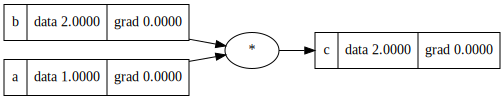

In [13]:
draw_dot(c)

In [14]:
c.grad = 1.0
b.grad = 0.0
a.grad = 0.0

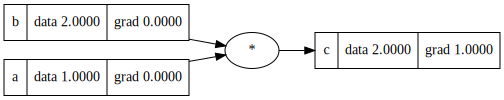

In [15]:
draw_dot(c)

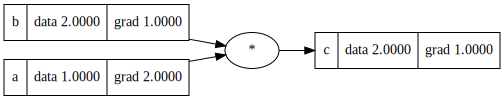

In [16]:
c.backward()
draw_dot(c)

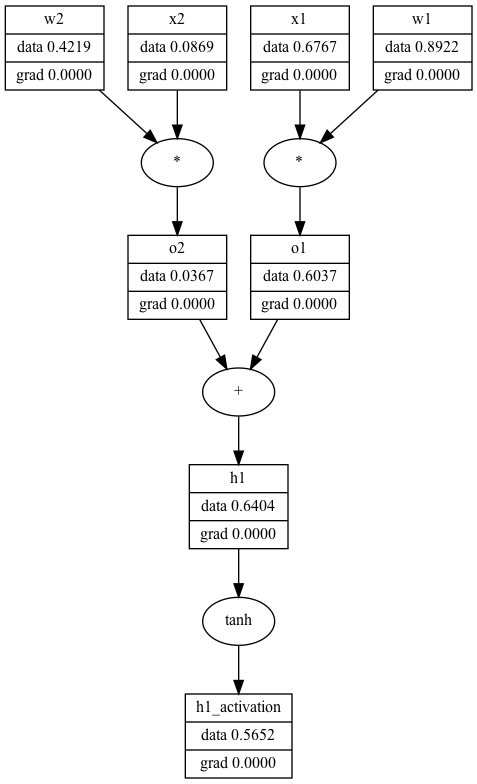

In [17]:
dot = draw_dot(h1_activation, rankdir='TB')
dot.edge_attr.update(minlen='1.0')
dot.node_attr.update(height='0.5', fontsize='12')
dot.graph_attr.update(lheight='0.1')
display_png(dot)

In [18]:
# Re-draw for the sake of blog post
b1 = Value(random.random())
x1 = Value(2.0)
w1 = Value(3.0)
x2 = Value(4.0)
w2 = Value(5.0)

o1 = x1 * w1
o2 = x2 * w2

h1 = o1 + o2

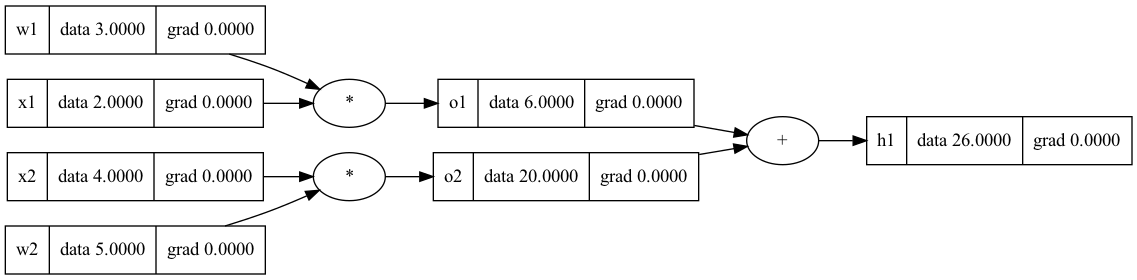

In [19]:
display_png(draw_dot(h1))

In [20]:
h1.grad = 2.0

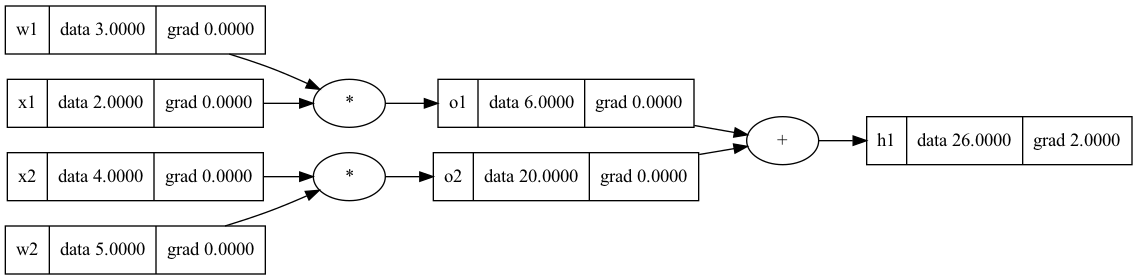

In [21]:
display_png(draw_dot(h1))

In [22]:
h1._backward()

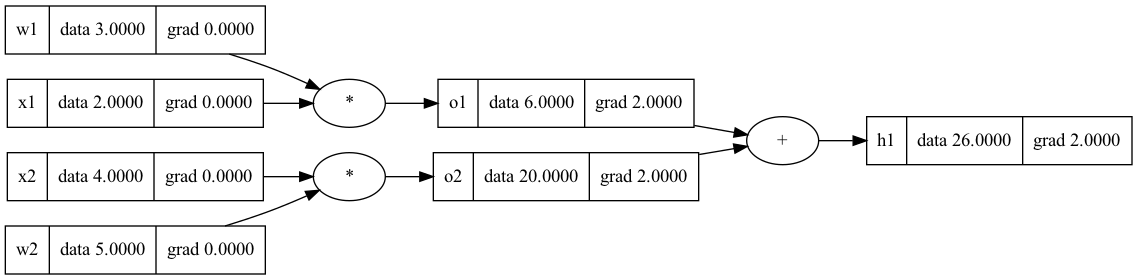

In [23]:
display_png(draw_dot(h1))

In [24]:
o1._backward()
o2._backward()

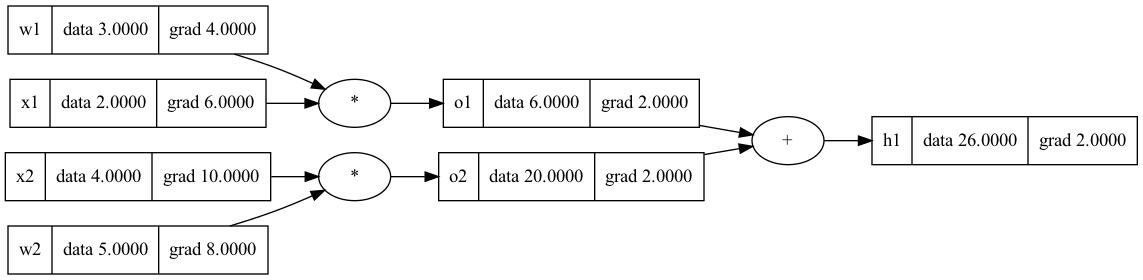

In [25]:
display_png(draw_dot(h1))

In [26]:
lr = 0.01
h1.zero_grad()
children = [child for child in h1.children]
while children:
    child = children.pop()
    if child.grad == 8.0 or child.grad == 4.0: # really hacky for visualization...
        child.data -= child.grad * lr
    if child.children:
        children += list(child.children)

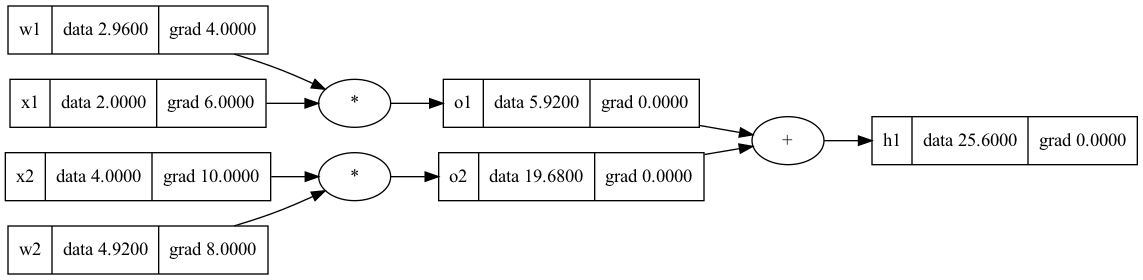

In [27]:
o1 = x1 * w1
o2 = x2 * w2
h1 = o1 + o2
display_png(draw_dot(h1))

In [28]:
and_train_data = [[0, 1, 0], [1, 1, 1], [1, 0, 0], [0, 0, 0]]
w1 = Value(0.5)
w2 = Value(0.5)
w3 = Value(0.5)
w4 = Value(0.5)

In [29]:
# Generate training and validation data
n_train = 300
n_val = 150
ims = []
train = gen_training_data(n_train, threshold)
validation = gen_training_data(n_val, threshold)

In [30]:
def get_decision_boundary(network, epoch, num_neurons=2):
    title = f'Decision Boundary ({epoch} Epochs; {num_neurons} ' + ('Neuron)' if num_neurons == 1 else 'Neurons)')
    axs.set_title(title)

    for idx, input_ in enumerate(x_in):
        pred = network.forward(input_)
        preds[idx] = round(pred[0].data)

    artist = axs.contourf(xx, yy, preds.reshape(xx.shape), cmap=plt.cm.RdBu, alpha=0.7)
    
    return artist, axs

In [31]:
def get_stats(network, data):
    hits = []
    losses = []
    for instance in data:
        x1,x2,y = instance
        pred = network.forward([x1, x2])
        hits.append(1 if round(pred[0].data) == y else 0)
        loss = network.compute_loss(pred, y)
        losses.append(loss.data)
    return (sum(hits) / len(hits), sum(losses) / len(losses))

Train accuracy: 0.5266666666666666
Avg train loss: 0.5422518189681736
Validation accuracy: 0.43333333333333335
Avg validation loss: 0.6376429805030367
************  EPOCH 1  ************
Train accuracy: 0.49333333333333335
Avg train loss: 0.25829859390187815
Validation accuracy: 0.4666666666666667
Avg validation loss: 0.25908252931423975

************  EPOCH 2  ************
Train accuracy: 0.44666666666666666
Avg train loss: 0.2519177916172202
Validation accuracy: 0.4
Avg validation loss: 0.25335204572407394

************  EPOCH 3  ************
Train accuracy: 0.5266666666666666
Avg train loss: 0.2491867470544841
Validation accuracy: 0.43333333333333335
Avg validation loss: 0.25062010954271857

************  EPOCH 4  ************
Train accuracy: 0.48
Avg train loss: 0.24796885333247773
Validation accuracy: 0.52
Avg validation loss: 0.24895679656951808

************  EPOCH 5  ************
Train accuracy: 0.5
Avg train loss: 0.24732890709339184
Validation accuracy: 0.54
Avg validation lo

************  EPOCH 50  ************
Train accuracy: 0.61
Avg train loss: 0.22181448420755656
Validation accuracy: 0.6466666666666666
Avg validation loss: 0.21952153120723794

************  EPOCH 51  ************
Train accuracy: 0.61
Avg train loss: 0.2215675616365037
Validation accuracy: 0.6466666666666666
Avg validation loss: 0.21930746495125747

************  EPOCH 52  ************
Train accuracy: 0.6166666666666667
Avg train loss: 0.22133277416985297
Validation accuracy: 0.6466666666666666
Avg validation loss: 0.21910493167245026

************  EPOCH 53  ************
Train accuracy: 0.6166666666666667
Avg train loss: 0.22110940791977324
Validation accuracy: 0.6466666666666666
Avg validation loss: 0.2189132011951593

************  EPOCH 54  ************
Train accuracy: 0.6133333333333333
Avg train loss: 0.22089679098608278
Validation accuracy: 0.6466666666666666
Avg validation loss: 0.21873159146403395

************  EPOCH 55  ************
Train accuracy: 0.6133333333333333
Avg trai

************  EPOCH 100  ************
Train accuracy: 0.63
Avg train loss: 0.21658858082969532
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21540105765292586

************  EPOCH 101  ************
Train accuracy: 0.63
Avg train loss: 0.21654677010238127
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21537690045623853

************  EPOCH 102  ************
Train accuracy: 0.63
Avg train loss: 0.2165058007721888
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21535363159494825

************  EPOCH 103  ************
Train accuracy: 0.63
Avg train loss: 0.21646563468926658
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21533122033287946

************  EPOCH 104  ************
Train accuracy: 0.63
Avg train loss: 0.21642623560908067
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21530963746528614

************  EPOCH 105  ************
Train accuracy: 0.6266666666666667
Avg train loss: 0.21638756909672685
Validat

************  EPOCH 146  ************
Train accuracy: 0.6266666666666667
Avg train loss: 0.21517514301336993
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21490416112883992

************  EPOCH 147  ************
Train accuracy: 0.6266666666666667
Avg train loss: 0.21515112495277638
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21490247718181446

************  EPOCH 148  ************
Train accuracy: 0.6266666666666667
Avg train loss: 0.21512728741121975
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21490102706983705

************  EPOCH 149  ************
Train accuracy: 0.6266666666666667
Avg train loss: 0.2151036280004558
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.2148998030156697

************  EPOCH 150  ************
Train accuracy: 0.6266666666666667
Avg train loss: 0.21508014447708979
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21489879732038167

************  EPOCH 151  ************
Train acc

Train accuracy: 0.6233333333333333
Avg train loss: 0.21423220320805858
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21496790153010015

************  EPOCH 193  ************
Train accuracy: 0.6233333333333333
Avg train loss: 0.21421489051526
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21497064604581548

************  EPOCH 194  ************
Train accuracy: 0.6233333333333333
Avg train loss: 0.21419769292053634
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21497339466928542

************  EPOCH 195  ************
Train accuracy: 0.6233333333333333
Avg train loss: 0.21418060920551174
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.2149761458074722

************  EPOCH 196  ************
Train accuracy: 0.6233333333333333
Avg train loss: 0.21416363816240042
Validation accuracy: 0.6533333333333333
Avg validation loss: 0.21497889798119402

************  EPOCH 197  ************
Train accuracy: 0.6233333333333333
Avg train loss

************  EPOCH 39  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16538347959992078
Validation accuracy: 0.7066666666666667
Avg validation loss: 0.18727054225249426

************  EPOCH 40  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16537968318460097
Validation accuracy: 0.7066666666666667
Avg validation loss: 0.1872751072913986

************  EPOCH 41  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16537577192040886
Validation accuracy: 0.7066666666666667
Avg validation loss: 0.18727823199191082

************  EPOCH 42  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.165371764353934
Validation accuracy: 0.7
Avg validation loss: 0.18728019180222227

************  EPOCH 43  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16536767702563482
Validation accuracy: 0.7
Avg validation loss: 0.18728121339849296

************  EPOCH 44  ************
Train accuracy: 0.7566666666666667
Avg train l

************  EPOCH 87  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16517775574490648
Validation accuracy: 0.7
Avg validation loss: 0.18722029138783075

************  EPOCH 88  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16517351643804587
Validation accuracy: 0.7
Avg validation loss: 0.18721975805184116

************  EPOCH 89  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.1651692824683815
Validation accuracy: 0.7
Avg validation loss: 0.18721926636410094

************  EPOCH 90  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.1651650538714073
Validation accuracy: 0.7
Avg validation loss: 0.1872188155236541

************  EPOCH 91  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16516083068207615
Validation accuracy: 0.7
Avg validation loss: 0.18721840474703694

************  EPOCH 92  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16515661293471715
Validation accuracy:

Train accuracy: 0.76
Avg train loss: 0.16496492921291742
Validation accuracy: 0.7
Avg validation loss: 0.1872340614301408

************  EPOCH 140  ************
Train accuracy: 0.76
Avg train loss: 0.16496099435837508
Validation accuracy: 0.7
Avg validation loss: 0.18723493962771443

************  EPOCH 141  ************
Train accuracy: 0.76
Avg train loss: 0.16495706550336112
Validation accuracy: 0.7
Avg validation loss: 0.1872358347263779

************  EPOCH 142  ************
Train accuracy: 0.76
Avg train loss: 0.1649531426426841
Validation accuracy: 0.7
Avg validation loss: 0.18723674647888922

************  EPOCH 143  ************
Train accuracy: 0.76
Avg train loss: 0.16494922577087118
Validation accuracy: 0.7
Avg validation loss: 0.18723767464354413

************  EPOCH 144  ************
Train accuracy: 0.76
Avg train loss: 0.16494531488218533
Validation accuracy: 0.7
Avg validation loss: 0.18723861898404967

************  EPOCH 145  ************
Train accuracy: 0.76
Avg train 

************  EPOCH 188  ************
Train accuracy: 0.76
Avg train loss: 0.16477904845938565
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.18729337520776518

************  EPOCH 189  ************
Train accuracy: 0.76
Avg train loss: 0.16477539911907346
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.18729486999729725

************  EPOCH 190  ************
Train accuracy: 0.7633333333333333
Avg train loss: 0.16477175541821515
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.1872963741880364

************  EPOCH 191  ************
Train accuracy: 0.7633333333333333
Avg train loss: 0.16476811735019284
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.18729788769200392

************  EPOCH 192  ************
Train accuracy: 0.7633333333333333
Avg train loss: 0.16476448490847545
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.18729941042279635

************  EPOCH 193  ************
Train accuracy: 0.7633333333333333
A

************  EPOCH 34  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.1654273349231275
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.18825891888942756

************  EPOCH 35  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16541790025338984
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.18825351221682654

************  EPOCH 36  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16540404233025766
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.18824552489427274

************  EPOCH 37  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.1653859918011336
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.1882346137892301

************  EPOCH 38  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16536388741700903
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.18822047666039063

************  EPOCH 39  ************
Train accuracy: 

************  EPOCH 81  ************
Train accuracy: 0.94
Avg train loss: 0.07212148766700656
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07937542411533653

************  EPOCH 82  ************
Train accuracy: 0.9333333333333333
Avg train loss: 0.07127071644775314
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07828100590261299

************  EPOCH 83  ************
Train accuracy: 0.9333333333333333
Avg train loss: 0.07053449546275362
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07732597116813353

************  EPOCH 84  ************
Train accuracy: 0.9333333333333333
Avg train loss: 0.06989486875607738
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07648775193630661

************  EPOCH 85  ************
Train accuracy: 0.9333333333333333
Avg train loss: 0.06933715309003934
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07574858085260408

************  EPOCH 86  ************
Train accuracy: 0.936666666

************  EPOCH 129  ************
Train accuracy: 0.94
Avg train loss: 0.06502448623108915
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.06936550933138586

************  EPOCH 130  ************
Train accuracy: 0.94
Avg train loss: 0.06502348077361199
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.06936890783339883

************  EPOCH 131  ************
Train accuracy: 0.94
Avg train loss: 0.06502293663151958
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.0693738827088158

************  EPOCH 132  ************
Train accuracy: 0.94
Avg train loss: 0.06502280598894963
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.06938036861036516

************  EPOCH 133  ************
Train accuracy: 0.94
Avg train loss: 0.06502304468300575
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.06938830555527258

************  EPOCH 134  ************
Train accuracy: 0.94
Avg train loss: 0.06502361185100292
Validation accuracy: 

************  EPOCH 176  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.06503863049033325
Validation accuracy: 0.92
Avg validation loss: 0.07070716786296449

************  EPOCH 177  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.0650339635732747
Validation accuracy: 0.92
Avg validation loss: 0.07075676800336894

************  EPOCH 178  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.06502888062334683
Validation accuracy: 0.92
Avg validation loss: 0.07080716749836104

************  EPOCH 179  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.06502336987719458
Validation accuracy: 0.92
Avg validation loss: 0.07085836408565786

************  EPOCH 180  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.06501741958108412
Validation accuracy: 0.92
Avg validation loss: 0.07091035525618014

************  EPOCH 181  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.06501101799553824
Validat

************  EPOCH 22  ************
Train accuracy: 0.76
Avg train loss: 0.16806605375570582
Validation accuracy: 0.7666666666666667
Avg validation loss: 0.16732931713949892

************  EPOCH 23  ************
Train accuracy: 0.76
Avg train loss: 0.16797865941564244
Validation accuracy: 0.76
Avg validation loss: 0.16733753409350358

************  EPOCH 24  ************
Train accuracy: 0.76
Avg train loss: 0.16790099738358996
Validation accuracy: 0.7533333333333333
Avg validation loss: 0.16734775959644146

************  EPOCH 25  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16783133913867287
Validation accuracy: 0.7533333333333333
Avg validation loss: 0.1673590579686877

************  EPOCH 26  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.16776823285610387
Validation accuracy: 0.7533333333333333
Avg validation loss: 0.16737068640784764

************  EPOCH 27  ************
Train accuracy: 0.7566666666666667
Avg train loss: 0.1677104314706124


************  EPOCH 68  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.07865125753028494
Validation accuracy: 0.9333333333333333
Avg validation loss: 0.08969509619404867

************  EPOCH 69  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.0766333097969837
Validation accuracy: 0.94
Avg validation loss: 0.08761418989087949

************  EPOCH 70  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.07503835187701884
Validation accuracy: 0.94
Avg validation loss: 0.08590217595529638

************  EPOCH 71  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.0737466799550288
Validation accuracy: 0.94
Avg validation loss: 0.08446713520393073

************  EPOCH 72  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.07268373404131946
Validation accuracy: 0.94
Avg validation loss: 0.08325202421959212

************  EPOCH 73  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.07179898614418333


************  EPOCH 115  ************
Train accuracy: 0.93
Avg train loss: 0.0654730696855626
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07438146819796772

************  EPOCH 116  ************
Train accuracy: 0.93
Avg train loss: 0.06543013176382986
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07434910538510978

************  EPOCH 117  ************
Train accuracy: 0.93
Avg train loss: 0.06538700252448303
Validation accuracy: 0.92
Avg validation loss: 0.07431748033175868

************  EPOCH 118  ************
Train accuracy: 0.93
Avg train loss: 0.06534366305380712
Validation accuracy: 0.92
Avg validation loss: 0.0742865440600519

************  EPOCH 119  ************
Train accuracy: 0.93
Avg train loss: 0.06530009884182351
Validation accuracy: 0.92
Avg validation loss: 0.0742562532356262

************  EPOCH 120  ************
Train accuracy: 0.93
Avg train loss: 0.06525629907029164
Validation accuracy: 0.92
Avg validation loss: 0.0742265693548166

************  EPOCH 162  ************
Train accuracy: 0.9233333333333333
Avg train loss: 0.0631835154236801
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07323474649028114

************  EPOCH 163  ************
Train accuracy: 0.9233333333333333
Avg train loss: 0.06312955992503838
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07321255144718736

************  EPOCH 164  ************
Train accuracy: 0.9233333333333333
Avg train loss: 0.0630756760061066
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07319040103746097

************  EPOCH 165  ************
Train accuracy: 0.9233333333333333
Avg train loss: 0.06302191684575144
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07316831513084902

************  EPOCH 166  ************
Train accuracy: 0.9233333333333333
Avg train loss: 0.06296833914929427
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07314631522103617

************  EPOCH 167  ************
Train acc

************  EPOCH 7  ************
Train accuracy: 0.73
Avg train loss: 0.17917008196857556
Validation accuracy: 0.7133333333333334
Avg validation loss: 0.1892318011016973

************  EPOCH 8  ************
Train accuracy: 0.74
Avg train loss: 0.1737341010428674
Validation accuracy: 0.7266666666666667
Avg validation loss: 0.18472035635665235

************  EPOCH 9  ************
Train accuracy: 0.76
Avg train loss: 0.16776666731250156
Validation accuracy: 0.7333333333333333
Avg validation loss: 0.1796697058532926

************  EPOCH 10  ************
Train accuracy: 0.7633333333333333
Avg train loss: 0.1613211295856724
Validation accuracy: 0.74
Avg validation loss: 0.1740768069514609

************  EPOCH 11  ************
Train accuracy: 0.78
Avg train loss: 0.15438715605211678
Validation accuracy: 0.7466666666666667
Avg validation loss: 0.16787363143286915

************  EPOCH 12  ************
Train accuracy: 0.7933333333333333
Avg train loss: 0.14687972235695865
Validation accuracy:

Train accuracy: 0.9633333333333334
Avg train loss: 0.058299409907187044
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07596511659934498

************  EPOCH 53  ************
Train accuracy: 0.96
Avg train loss: 0.05821670673027588
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07592844037972359

************  EPOCH 54  ************
Train accuracy: 0.96
Avg train loss: 0.058141017702910414
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07589548674940247

************  EPOCH 55  ************
Train accuracy: 0.9566666666666667
Avg train loss: 0.05807165726162118
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07586582865888614

************  EPOCH 56  ************
Train accuracy: 0.9566666666666667
Avg train loss: 0.05800799951901647
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07583908717924802

************  EPOCH 57  ************
Train accuracy: 0.9566666666666667
Avg train loss: 0.05794947338791633
Valid

************  EPOCH 97  ************
Train accuracy: 0.96
Avg train loss: 0.05695077347170592
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07544145630123533

************  EPOCH 98  ************
Train accuracy: 0.96
Avg train loss: 0.05693364199249422
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07543419781430953

************  EPOCH 99  ************
Train accuracy: 0.96
Avg train loss: 0.05691660189171145
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07542692122461668

************  EPOCH 100  ************
Train accuracy: 0.96
Avg train loss: 0.05689965532221118
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07541963009346035

************  EPOCH 101  ************
Train accuracy: 0.96
Avg train loss: 0.05688280472767917
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07541232811490821

************  EPOCH 102  ************
Train accuracy: 0.96
Avg train loss: 0.05686605277426253
Validation accuracy: 0.

************  EPOCH 145  ************
Train accuracy: 0.96
Avg train loss: 0.056269825341826306
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07512470899412999

************  EPOCH 146  ************
Train accuracy: 0.96
Avg train loss: 0.05625911382730532
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07511946406750705

************  EPOCH 147  ************
Train accuracy: 0.96
Avg train loss: 0.05624853921700199
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07511428095445939

************  EPOCH 148  ************
Train accuracy: 0.96
Avg train loss: 0.056238100274759395
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07510915912868914

************  EPOCH 149  ************
Train accuracy: 0.96
Avg train loss: 0.05622779573350913
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07510409803132938

************  EPOCH 150  ************
Train accuracy: 0.96
Avg train loss: 0.05621762429839085
Validation accurac

Train accuracy: 0.96
Avg train loss: 0.055875174962289026
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.0749246427989382

************  EPOCH 196  ************
Train accuracy: 0.96
Avg train loss: 0.0558696457108944
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07492163421868156

************  EPOCH 197  ************
Train accuracy: 0.96
Avg train loss: 0.05586418810448836
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07491865356826465

************  EPOCH 198  ************
Train accuracy: 0.96
Avg train loss: 0.055858801108732245
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.0749157003374197

************  EPOCH 199  ************
Train accuracy: 0.96
Avg train loss: 0.05585348370371798
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07491277402600033

************  EPOCH 200  ************
Train accuracy: 0.96
Avg train loss: 0.055848234883881735
Validation accuracy: 0.9133333333333333
Avg validation los

************  EPOCH 40  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.06458613511759614
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.07485202443246369

************  EPOCH 41  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.064209418983098
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.07457207020022319

************  EPOCH 42  ************
Train accuracy: 0.95
Avg train loss: 0.06383292461569393
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.07429698673482961

************  EPOCH 43  ************
Train accuracy: 0.9533333333333334
Avg train loss: 0.06345720997320706
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.07402655684661404

************  EPOCH 44  ************
Train accuracy: 0.9533333333333334
Avg train loss: 0.06308296189859655
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.07376067547711017

************  EPOCH 45  ************
Train accuracy: 0.95
Avg trai

************  EPOCH 86  ************
Train accuracy: 0.9633333333333334
Avg train loss: 0.05552641305662978
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06810636377088383

************  EPOCH 87  ************
Train accuracy: 0.9633333333333334
Avg train loss: 0.055499015264308275
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06806798785842924

************  EPOCH 88  ************
Train accuracy: 0.9633333333333334
Avg train loss: 0.05547335128992499
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06803142735196666

************  EPOCH 89  ************
Train accuracy: 0.9633333333333334
Avg train loss: 0.055449233122568165
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06799659825221854

************  EPOCH 90  ************
Train accuracy: 0.9633333333333334
Avg train loss: 0.055426490085190246
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06796342117988545

************  EPOCH 91  ************
Train accu

Train accuracy: 0.96
Avg train loss: 0.054843915073320086
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06741929714736543

************  EPOCH 131  ************
Train accuracy: 0.96
Avg train loss: 0.054831985775554745
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06741677852923571

************  EPOCH 132  ************
Train accuracy: 0.96
Avg train loss: 0.05482021876871041
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06741456957803414

************  EPOCH 133  ************
Train accuracy: 0.96
Avg train loss: 0.05480862210588659
Validation accuracy: 0.94
Avg validation loss: 0.06741266094490884

************  EPOCH 134  ************
Train accuracy: 0.96
Avg train loss: 0.05479720354253336
Validation accuracy: 0.94
Avg validation loss: 0.0674110435664849

************  EPOCH 135  ************
Train accuracy: 0.96
Avg train loss: 0.05478597049326668
Validation accuracy: 0.94
Avg validation loss: 0.06740970864320849

************  EPO

************  EPOCH 175  ************
Train accuracy: 0.9566666666666667
Avg train loss: 0.054519087926049536
Validation accuracy: 0.9333333333333333
Avg validation loss: 0.06750774417073589

************  EPOCH 176  ************
Train accuracy: 0.9566666666666667
Avg train loss: 0.05451658425448751
Validation accuracy: 0.9333333333333333
Avg validation loss: 0.06751236699482195

************  EPOCH 177  ************
Train accuracy: 0.9566666666666667
Avg train loss: 0.05451423107407805
Validation accuracy: 0.9333333333333333
Avg validation loss: 0.06751703363743809

************  EPOCH 178  ************
Train accuracy: 0.9566666666666667
Avg train loss: 0.05451202386012317
Validation accuracy: 0.9333333333333333
Avg validation loss: 0.06752174077926239

************  EPOCH 179  ************
Train accuracy: 0.9566666666666667
Avg train loss: 0.05450995813494853
Validation accuracy: 0.9333333333333333
Avg validation loss: 0.06752648520000812

************  EPOCH 180  ************
Train 

************  EPOCH 19  ************
Train accuracy: 0.69
Avg train loss: 0.19544729113067252
Validation accuracy: 0.6933333333333334
Avg validation loss: 0.20450929108692206

************  EPOCH 20  ************
Train accuracy: 0.69
Avg train loss: 0.1939842281028838
Validation accuracy: 0.7
Avg validation loss: 0.20336666935140446

************  EPOCH 21  ************
Train accuracy: 0.69
Avg train loss: 0.19230852652125668
Validation accuracy: 0.7
Avg validation loss: 0.20196793015889897

************  EPOCH 22  ************
Train accuracy: 0.69
Avg train loss: 0.19038845337888868
Validation accuracy: 0.7
Avg validation loss: 0.20027396943944242

************  EPOCH 23  ************
Train accuracy: 0.6966666666666667
Avg train loss: 0.18818950619052832
Validation accuracy: 0.7
Avg validation loss: 0.19824420158624526

************  EPOCH 24  ************
Train accuracy: 0.6966666666666667
Avg train loss: 0.18567192419936038
Validation accuracy: 0.7066666666666667
Avg validation loss

************  EPOCH 65  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.06184883663022018
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07804174545950567

************  EPOCH 66  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.061764459624338075
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07801251383320776

************  EPOCH 67  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.061685205518162395
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07798760945656444

************  EPOCH 68  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.061610680018787424
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07796655853828709

************  EPOCH 69  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.061540535810286345
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07794893901714892

************  EPOCH 70  ************
Train acc

************  EPOCH 110  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.06047075935509087
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.07806341597614833

************  EPOCH 111  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.060464173775631486
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.07806818393448674

************  EPOCH 112  ************
Train accuracy: 0.9433333333333334
Avg train loss: 0.060457904847472384
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.07807281322678307

************  EPOCH 113  ************
Train accuracy: 0.94
Avg train loss: 0.06045193208281191
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.07807730328319645

************  EPOCH 114  ************
Train accuracy: 0.94
Avg train loss: 0.06044623617880845
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.07808165390630413

************  EPOCH 115  ************
Train accuracy: 0.94
Avg train lo

************  EPOCH 155  ************
Train accuracy: 0.9366666666666666
Avg train loss: 0.06031748068547076
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.07816109032082795

************  EPOCH 156  ************
Train accuracy: 0.9366666666666666
Avg train loss: 0.06031522099797719
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.07816134704581754

************  EPOCH 157  ************
Train accuracy: 0.9366666666666666
Avg train loss: 0.060312967516641516
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.07816155977971637

************  EPOCH 158  ************
Train accuracy: 0.9366666666666666
Avg train loss: 0.060310719388518286
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.07816173078883872

************  EPOCH 159  ************
Train accuracy: 0.9366666666666666
Avg train loss: 0.06030847582889173
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.07816186230399827

************  EPOCH 160  ************
Train

************  EPOCH 200  ************
Train accuracy: 0.9366666666666666
Avg train loss: 0.06021560377663449
Validation accuracy: 0.9
Avg validation loss: 0.07815624687989195

Train accuracy: 0.28
Avg train loss: 0.7837583031360101
Validation accuracy: 0.32
Avg validation loss: 0.705616770710365
************  EPOCH 1  ************
Train accuracy: 0.8466666666666667
Avg train loss: 0.16283576836473249
Validation accuracy: 0.8133333333333334
Avg validation loss: 0.17375101725050038

************  EPOCH 2  ************
Train accuracy: 0.8666666666666667
Avg train loss: 0.13926099564112754
Validation accuracy: 0.84
Avg validation loss: 0.15585026010423267

************  EPOCH 3  ************
Train accuracy: 0.8833333333333333
Avg train loss: 0.12131391611165734
Validation accuracy: 0.8466666666666667
Avg validation loss: 0.13752626260143597

************  EPOCH 4  ************
Train accuracy: 0.9
Avg train loss: 0.10665534751738523
Validation accuracy: 0.8533333333333334
Avg validation los

************  EPOCH 46  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.062214538620298715
Validation accuracy: 0.8866666666666667
Avg validation loss: 0.07918618718557789

************  EPOCH 47  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.062180937650203834
Validation accuracy: 0.8866666666666667
Avg validation loss: 0.07916920013073254

************  EPOCH 48  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.0621478773833253
Validation accuracy: 0.8866666666666667
Avg validation loss: 0.07915100665069204

************  EPOCH 49  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.062115249461876076
Validation accuracy: 0.8866666666666667
Avg validation loss: 0.0791315843839301

************  EPOCH 50  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.062082956474700725
Validation accuracy: 0.8866666666666667
Avg validation loss: 0.07911091831792419

************  EPOCH 51  ************
Train accur

************  EPOCH 91  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.06037343450113088
Validation accuracy: 0.9066666666666666
Avg validation loss: 0.0772835050249196

************  EPOCH 92  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.060312800762959154
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07722082329038842

************  EPOCH 93  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.06025124139250817
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07715780862726057

************  EPOCH 94  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.06018879887029742
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07709451574668734

************  EPOCH 95  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.060125519699738054
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07703099908368267

************  EPOCH 96  ************
Train accura

************  EPOCH 136  ************
Train accuracy: 0.9733333333333334
Avg train loss: 0.05745136579241797
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07458043171075196

************  EPOCH 137  ************
Train accuracy: 0.9733333333333334
Avg train loss: 0.05739392361790931
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07452510547345655

************  EPOCH 138  ************
Train accuracy: 0.9733333333333334
Avg train loss: 0.05733697199107289
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07446985038059965

************  EPOCH 139  ************
Train accuracy: 0.9733333333333334
Avg train loss: 0.05728050472028457
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07441465787935408

************  EPOCH 140  ************
Train accuracy: 0.9733333333333334
Avg train loss: 0.05722451540197273
Validation accuracy: 0.92
Avg validation loss: 0.07435952010847294

************  EPOCH 141  ************
Train accuracy: 0.973

************  EPOCH 183  ************
Train accuracy: 0.97
Avg train loss: 0.05519576991774764
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07201362333850839

************  EPOCH 184  ************
Train accuracy: 0.97
Avg train loss: 0.055156211471821225
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07196013278862795

************  EPOCH 185  ************
Train accuracy: 0.97
Avg train loss: 0.05511695354402381
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07190672658132931

************  EPOCH 186  ************
Train accuracy: 0.97
Avg train loss: 0.0550779925364825
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07185340631002762

************  EPOCH 187  ************
Train accuracy: 0.97
Avg train loss: 0.05503932476582726
Validation accuracy: 0.9266666666666666
Avg validation loss: 0.07180017342457072

************  EPOCH 188  ************
Train accuracy: 0.97
Avg train loss: 0.05500094646595618
Validation accuracy:

************  EPOCH 28  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.0666661779859777
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07905460019114183

************  EPOCH 29  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.066576406946479
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.0790358119069559

************  EPOCH 30  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.06650914447834783
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07903412094343004

************  EPOCH 31  ************
Train accuracy: 0.95
Avg train loss: 0.06645756737174273
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07904238045794915

************  EPOCH 32  ************
Train accuracy: 0.9466666666666667
Avg train loss: 0.06641604231733265
Validation accuracy: 0.9133333333333333
Avg validation loss: 0.07905482096658188

************  EPOCH 33  ************
Train accuracy: 0.9466666666666

************  EPOCH 75  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.059259855738460286
Validation accuracy: 0.94
Avg validation loss: 0.0730238850591067

************  EPOCH 76  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.05915137692708936
Validation accuracy: 0.94
Avg validation loss: 0.0729473356299895

************  EPOCH 77  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.05904639134897027
Validation accuracy: 0.94
Avg validation loss: 0.07287206126298304

************  EPOCH 78  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.05894456871472936
Validation accuracy: 0.94
Avg validation loss: 0.0727976832258498

************  EPOCH 79  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.058845609770361317
Validation accuracy: 0.94
Avg validation loss: 0.07272387110791219

************  EPOCH 80  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.058749243633555846
Validation a

************  EPOCH 121  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.05561234956588287
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.0689450085675623

************  EPOCH 122  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.05554370880832385
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06884157651410303

************  EPOCH 123  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.055475351438237404
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06873810190572496

************  EPOCH 124  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.05540728261382455
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06863462298329673

************  EPOCH 125  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.055339507551252026
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06853117662634885

************  EPOCH 126  ************
Train 

************  EPOCH 164  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.05296765515962608
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06477558820196626

************  EPOCH 165  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.052914388217773445
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06469008432518202

************  EPOCH 166  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.0528615050303628
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06460519939572906

************  EPOCH 167  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.05280900469541989
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06452093422600315

************  EPOCH 168  ************
Train accuracy: 0.9666666666666667
Avg train loss: 0.052756886219316304
Validation accuracy: 0.9466666666666667
Avg validation loss: 0.06443728933966278

************  EPOCH 169  ************
Train 

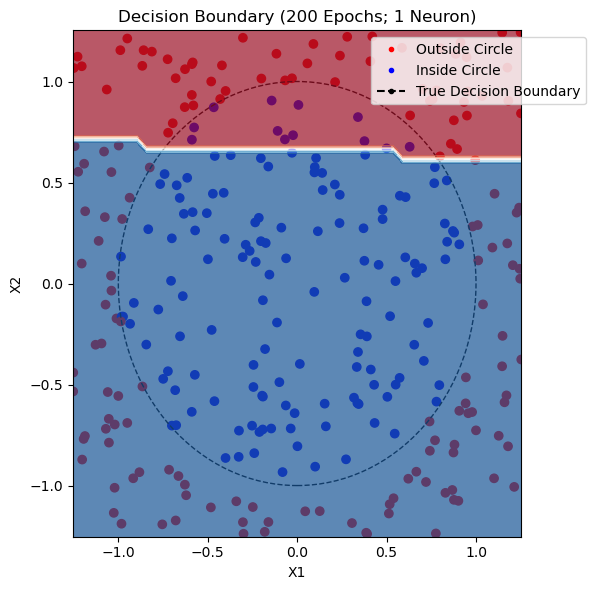

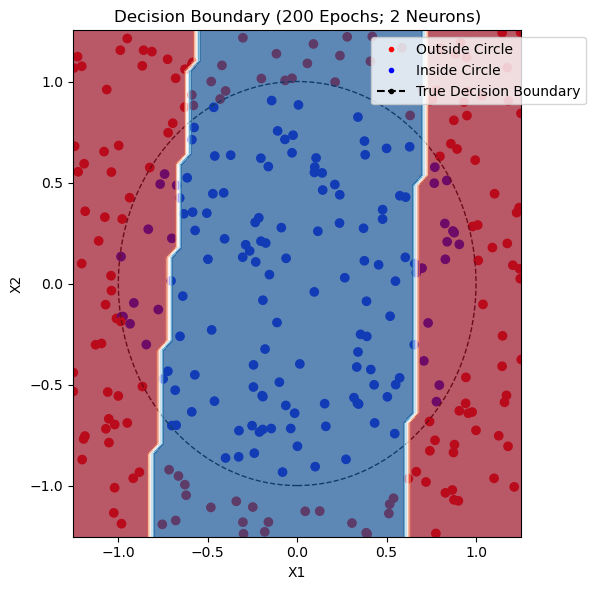

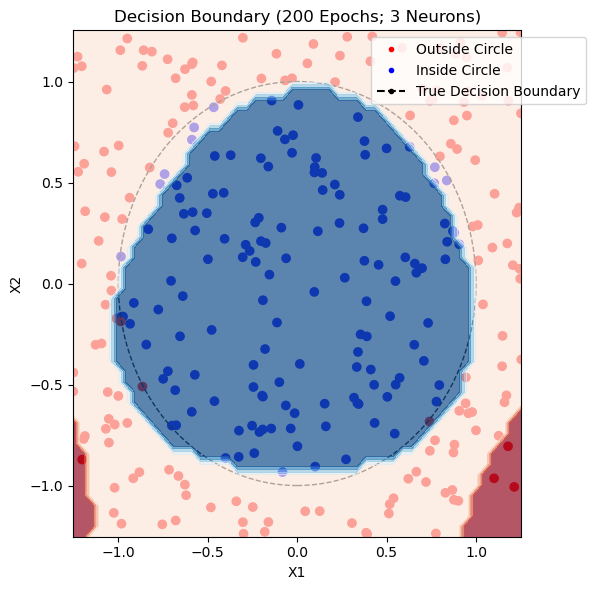

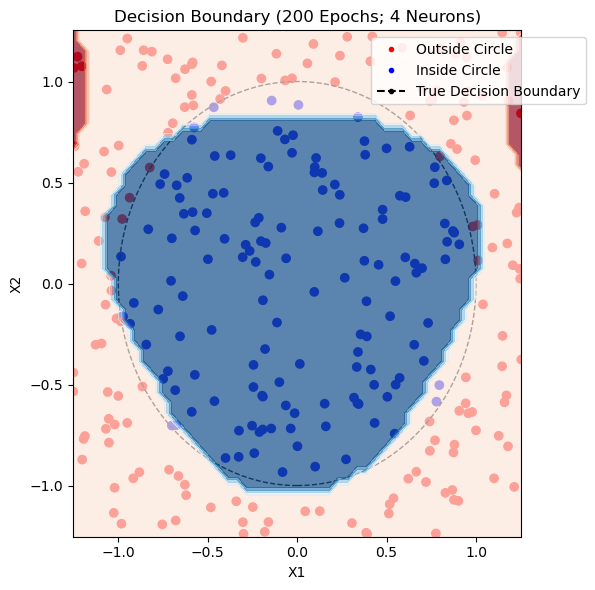

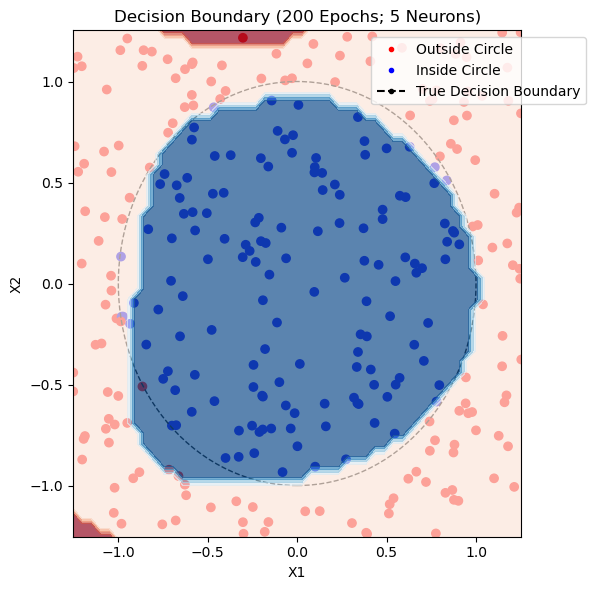

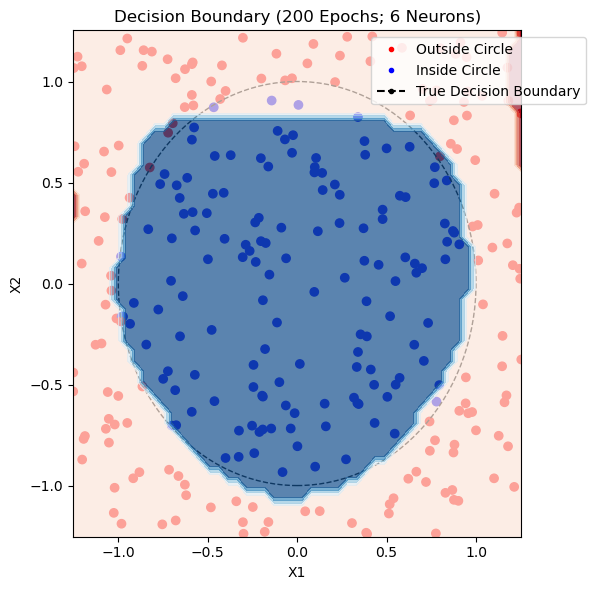

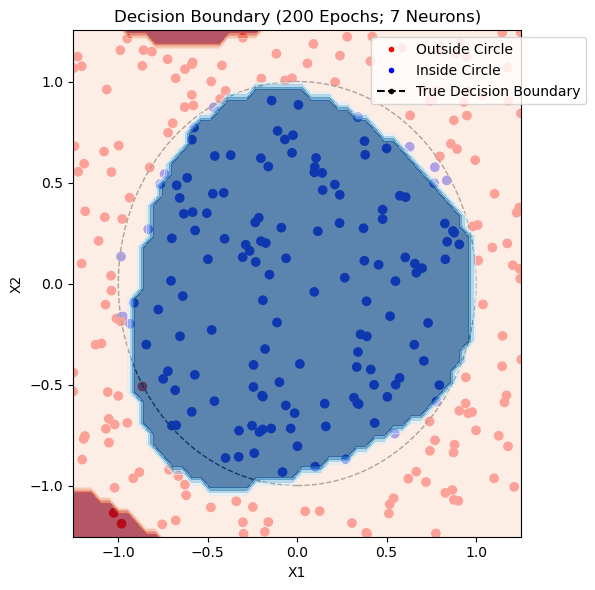

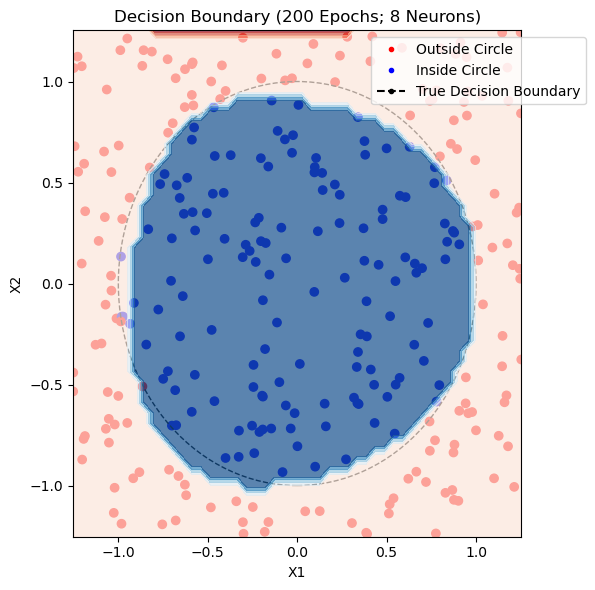

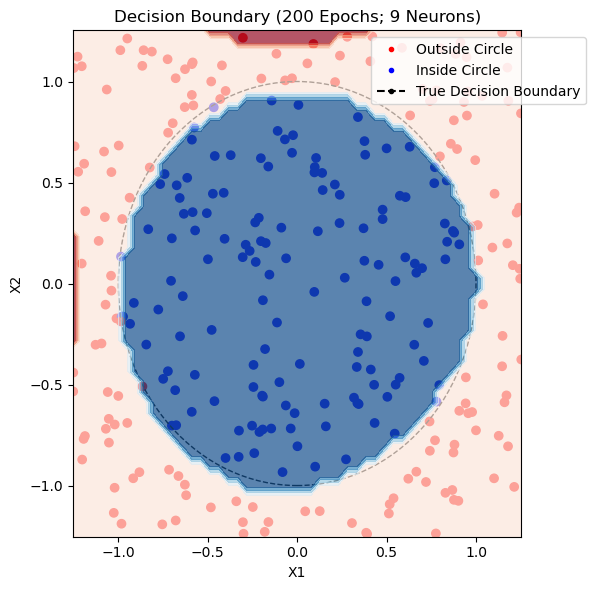

In [32]:
for num_neurons in range(1, 10):
    num_epochs = 200
    optim = SGD(lr=0.01)
    # num_neurons = 2
    network = NeuralNetwork(2, [num_neurons, 1], optim)

    # This was adapted from this helpful blog post: 
    #   https://psrivasin.medium.com/plotting-decision-boundaries-using-numpy-and-matplotlib-f5613d8acd19
    ims = []
    xx, yy = np.meshgrid(np.linspace(-threshold/2,threshold/2, 50), np.linspace(-threshold/2,threshold/2, 50))
    x_in = np.c_[xx.ravel(), yy.ravel()].tolist()
    preds = np.ndarray(len(x_in))
    for idx, input_ in enumerate(x_in):
        preds[idx] = round(network.forward(input_)[0].data)

    preds = preds.reshape(xx.shape)
    cdict = {0: 'blue', 1: 'red'}
    all_data = train + validation

    x1 = [x[0] for x in train]
    x2 = [x[1] for x in train]
    color = ['blue' if x[2] == 1 else 'red' for x in train]

    custom = [Line2D([], [], marker='.', color='red', linestyle='None'),
              Line2D([], [], marker='.', color='blue', linestyle='None'),
              Line2D([], [], marker='.', color='black', linestyle='--')
             ]
    fig, axs = plt.subplots(figsize=(6,6))
    ims.append(axs.contourf(xx, yy, preds, cmap=plt.cm.RdBu, alpha=0.7))
    axs.scatter(x1, x2, c=color, label=color)
    axs.set_xlim(-threshold/2,threshold/2)
    axs.set_ylim(-threshold/2,threshold/2)
    circ = plt.Circle((0, 0), 1.0, color='black', linewidth=1, fill=False, linestyle='--')
    axs.legend(handles = custom, labels=['Outside Circle', 'Inside Circle', 'True Decision Boundary'], bbox_to_anchor= (.65, 1.0), loc= "upper left")
    axs.add_patch(circ)
    axs.set_xlabel('X1')
    axs.set_ylabel('X2')
    axs.set_title('Initial Decision Boundary')
    xx, yy = np.meshgrid(np.linspace(-threshold/2,threshold/2, 50), np.linspace(-threshold/2,threshold/2, 50))
    x_in = np.c_[xx.ravel(), yy.ravel()].tolist()
    preds = np.ndarray(len(x_in))

    idx = [1 + x for x in range(num_epochs)]
    train_accuracies = []
    val_accuracies = []
    train_losses = []
    val_losses = []

    train_accuracy, train_loss = get_stats(network, train)
    val_accuracy, val_loss = get_stats(network, validation)
    print('Train accuracy: {}'.format(train_accuracy))
    print('Avg train loss: {}'.format(train_loss))
    print('Validation accuracy: {}'.format(val_accuracy))
    print('Avg validation loss: {}'.format(val_loss))
    fig.tight_layout()
    
    for epoch in range(num_epochs):
        print(f'************  EPOCH {epoch + 1}  ************'.format(str(epoch)))
        losses = []
        for instance in train:
            x1_data, x2_data, y_data = instance
            pred = network.forward([x1_data, x2_data])
            loss = network.compute_loss(pred, y_data)
            loss.backward()
            network.update()
            network.zero_grad()
            losses.append(loss.data)

        train_accuracy, train_loss = get_stats(network, train)
        val_accuracy, val_loss = get_stats(network, validation)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print('Train accuracy: {}'.format(train_accuracy))
        print('Avg train loss: {}'.format(train_loss))
        print('Validation accuracy: {}'.format(val_accuracy))
        print('Avg validation loss: {}'.format(val_loss))
        print('')


        # Get decision boundary after epoch
        artist, _ = get_decision_boundary(network, epoch+1, num_neurons)
        ims.append(artist) 

    # Create animation for decision boundary
    ani = animation.ArtistAnimation(fig, [x.collections for x in ims], interval=30, blit=True, repeat_delay=4000)
    ani.save(f'{num_neurons}_neurons.gif')

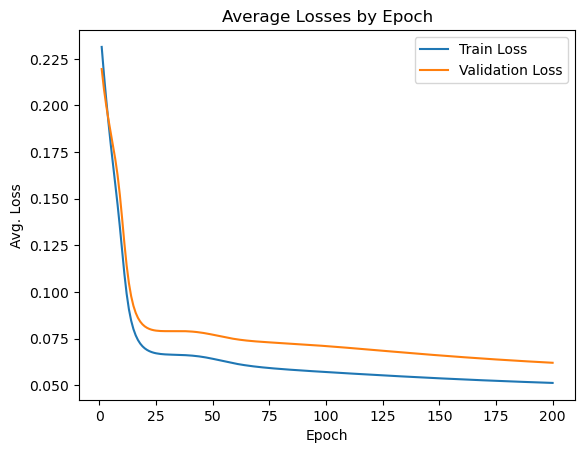

In [33]:
fig, ax = plt.subplots()
ax.plot(idx,train_losses, label='Train Loss')
ax.plot(idx,val_losses,label='Validation Loss')
ax.set_title('Average Losses by Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Avg. Loss')
ax.legend()

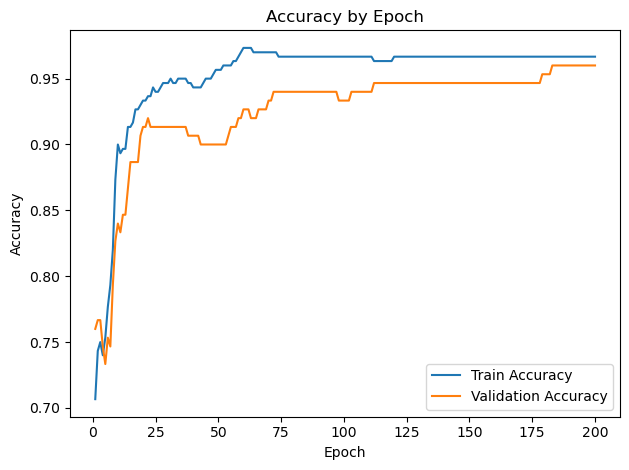

In [34]:
fig, ax = plt.subplots()
ax.plot(idx,train_accuracies, label='Train Accuracy')
ax.plot(idx,val_accuracies,label='Validation Accuracy')
ax.set_title('Accuracy by Epoch')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend()
plt.tight_layout()